### **1. Import Dependencies**

In [165]:
import pandas as pd
import numpy as np

from collections import Counter

import gc
import os
import requests
import json
import re

import concurrent.futures

from urllib.parse import urlencode

from typing import List, Dict, Optional, Union
from glob import glob


import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sentence_transformers import SentenceTransformer
from gensim.models import KeyedVectors 

import tensorflow as tf
import tensorflow.keras as keras

from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Bidirectional, Input, Reshape, Dot, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping

import faiss

from imblearn.over_sampling import RandomOverSampler

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\msi.pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\msi.pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **2. Settings**

In [166]:
tf.random.set_seed(42)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

### **3. Load Data**

Fetch the bug report data using [BugZilla API](https://bmo.readthedocs.io/en/latest/api/core/v1/bug.html#get-bug) then save it as json and Pandas.parquet.

In [167]:
def fetch_data(url: str, params=None):
  try:
    response = requests.get(url, params=params)
    if (response.status_code == 200):
      return response.json()
    
    print(f"Error response with status code: {response.status_code}")
  except Exception as error:
    print(f'Failed to fetch data: {error}')


def urls_builder(base_url: str, n_fetch: int, limit: int, products: List[str], **kwargs):
  urls = []
  for product in products:
    for i in range(n_fetch):
      param = {'offset': i * limit, 'limit': limit, 'product': product, **kwargs}
      full_url = base_url + '?' + urlencode(param)
      urls.append(full_url)
    
  return urls


def save_json(data, path: str):
  with open(path, 'w') as json_file:
    json.dump(data, json_file)


def load_json(path: str):
  with open(path, 'r') as json_file:
    loaded_data = json.load(json_file)
  return loaded_data

In [17]:
%%script skipped # Skipped

selected_fields = ['id', 'duplicates', 'summary', 'description', 'status', 'resolution', 'platform', 'product', 'type', 'priority', 'severity', 'component']
products = ['Firefox']

base_params = {'include_fields': ', '.join(selected_fields)}
saved_data_path = os.path.join('data', 'raw_data', 'firefox_raw_data.json')

base_url = 'https://bugzilla.mozilla.org/rest/bug'
n_fetch, limit = 50, 100

if os.path.exists(saved_data_path):
  response_data = load_json(saved_data_path)
else:
  urls = urls_builder(base_url, n_fetch, limit, products, **base_params)
  response_data = []

  max_workers = 50
  with concurrent.futures.ThreadPoolExecutor(max_workers) as executor:
    response_data = list(executor.map(fetch_data, urls))
    
  response_data = [item['bugs'] for item in response_data]
  response_data = [item for sublist in response_data for item in sublist]
  
  save_json(response_data, saved_data_path)

In [84]:
raw_data_path = os.path.join('data', 'cache', 'raw_data.parquet')
df = pd.DataFrame()

if (os.path.exists(raw_data_path)):
  df = pd.read_parquet(raw_data_path)
else:
  data_paths = glob(os.path.join('data', 'raw_data', '*.json'))

  for path in data_paths:
    data = load_json(path)
    data = pd.DataFrame(data)
    df = pd.concat([df, data])

  df = df.set_index('id')
  df.to_parquet(raw_data_path)

df.head()

,component,status,resolution,summary,description,product,duplicates,severity,priority,type,platform
id,,,,,,,,,,,
10954,Settings UI,RESOLVED,WONTFIX,Dialup properties needs to be exposed in prefs,The dialup properties of the profile should be...,Firefox,[],normal,P3,enhancement,All
14871,General,RESOLVED,DUPLICATE,[Find] Find whole word only,"Please add ""Match Whole Word Only"" option to b...",Firefox,[],minor,--,defect,All
19118,Settings UI,RESOLVED,WONTFIX,Plug-In Manager (ui for choosing mimetype-plug...,I would really like a plug-in manager for my b...,Firefox,"[32380, 57760, 64040, 66644, 95646, 96695, 106...",normal,--,enhancement,All
21482,File Handling,NEW,,Improvement to Save File dialog: folder based ...,Perhaps this really should be in the standardi...,Firefox,[],S3,P3,enhancement,All
23207,File Handling,NEW,,"Options in Save As (location of saved images, ...",Save as... feature should be extended in follo...,Firefox,"[26366, 172317, 177285]",S3,P5,enhancement,Unspecified


In [85]:
df = df.drop(['status', 'priority', 'resolution', 'severity', 'type', 'product'], axis=1)

gc.collect()

7246

In [86]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 210693 entries, 10954 to 1876223
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   component    210693 non-null  object
 1   summary      210693 non-null  object
 2   description  210693 non-null  object
 3   duplicates   210693 non-null  object
 4   platform     210693 non-null  object
dtypes: object(5)
memory usage: 305.1 MB


### **3. EDA**

### **3.1. Missing Values**

It seems there is no missing value

In [87]:
df.isna().sum()

component      0
summary        0
description    0
duplicates     0
platform       0
dtype: int64

### **3.2. Product (*no longer used*)**

In [8]:
%%script skipped # Skipped

df['product'].value_counts(ascending=False)

Couldn't find program: 'skipped'


### **3.3. Platform**

In [36]:
df['platform'].value_counts(ascending=False)

platform
x86            84726
Unspecified    57693
All            35063
x86_64         19720
PowerPC         6528
Desktop         5729
Other            755
ARM              192
Sun              184
ARM64             60
HP                24
DEC                7
SGI                6
RISCV64            4
XScale             2
Name: count, dtype: int64

### **3.4. Type (*no longer used*)**

In [37]:
%%script skipped # Skipped

df['type'].value_counts(ascending=False)

Couldn't find program: 'skipped'


### **3.5. Duplicates**

We observe that 15,140 bug reports have been identified as duplicates by other reports.

In [88]:
duplicates = df['duplicates'].apply(lambda x: len(x)).sort_values(ascending=False)
duplicated_bugs = duplicates[duplicates > 0]

print(f'total of duplicated bugs: {duplicated_bugs.count()}')

total of duplicated bugs: 15140


### **4. Feature Engineering**

### **4.1. Missing Values (Skipped)**

In [39]:
%%script skipped # Skipped

df.loc[df['type'] == '--', 'type'] = 'no type'

Couldn't find program: 'skipped'


### **4.2. Duplicates**

In [89]:
df = df.loc[df.astype(str).drop_duplicates(keep='first').index]

### **4.2. Duplicates**

Presently, our dataset includes a field named `'duplicates'`, which comprises a list of report IDs identified as duplicates. To prepare the data for model training, we introduce a new feature named `'duplicates_to'`, derived from the information in the `'duplicates'` field.

In [90]:
duplicated = df.loc[duplicated_bugs.index, 'duplicates']
duplicated

id
246078     [239385, 239561, 246164, 246674, 246958, 24697...
247116     [247032, 254990, 255342, 256792, 257710, 25950...
210910     [197227, 210933, 211542, 212349, 212382, 21269...
69938      [79637, 87494, 105392, 107129, 116505, 121880,...
245392     [245393, 245694, 246339, 246486, 247750, 24788...
                                 ...                        
733886                                              [615920]
849859                                             [1235163]
1860453                                            [1860454]
875488                                              [886453]
194923                                              [301718]
Name: duplicates, Length: 15140, dtype: object

In [91]:
data_path = os.path.join('data', 'cache', 'duplicate_to_data.parquet')

if (os.path.exists(data_path)):
  df = pd.read_parquet(data_path)
else:
  df['duplicates_to'] = -1

  for idx, dups in zip(duplicated.index, duplicated):
    for item in dups:
      df.loc[df.index == item, 'duplicates_to'] = idx
      
  df.to_parquet(data_path)

In [92]:
df = df.drop(columns=['duplicates'])
gc.collect()

0

### **4.4. Combined Text**

In [93]:
df['text'] = df['platform'] + ' ' + df['component'] + ' ' + df['summary'] + ' ' + df['description']

In [94]:
df = df[['text', 'duplicates_to']]

df.head()

,text,duplicates_to
id,,
10954,All Settings UI Dialup properties needs to be ...,-1
14871,All General [Find] Find whole word only Please...,-1
19118,All Settings UI Plug-In Manager (ui for choosi...,-1
21482,All File Handling Improvement to Save File dia...,-1
23207,Unspecified File Handling Options in Save As (...,-1


In [95]:
duplicates_to = df['duplicates_to']

total_duplicates = duplicates_to[duplicates_to != -1].count()
total_uniques = duplicates_to[duplicates_to == -1].count()

print(f'Total duplicate reports: {total_duplicates}')
print(f'Total unique reports: {total_uniques}')

Total duplicate reports: 27230
Total unique reports: 183181


### **4.3. Clean Sentences**

Before performing embedding on the texts, it's necessary to preprocess the text data. This involves removing non-alphanumeric characters, newline characters, tab characters, return characters, single characters, and multiple spaces. Additionally, stopwords are removed using the stopwords provided by the `nltk` library. 

In [107]:
def remove_special_chars(text: str):
  text = text.lower()
  text = re.sub(r'\n|\t|\r|\0', ' ', text)
  text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
  text = re.sub(r'\s{2,}', ' ', text)
  text = re.sub(r'\s$', '', text)
  text = re.sub(r'\s[b-z]\s', ' ', text)
  text = re.sub(r'\s[b-z]\s', ' ', text)
  text = re.sub(r'\s{2,}', ' ', text)
  return text


def remove_stopwords(text: str):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  filtered_words = [word for word in words if word not in stop_words]
  return ' '.join(filtered_words)


def clean_text(text: str):
  text = remove_special_chars(text)
  text = remove_stopwords(text)
  return text


data_path = os.path.join('data', 'cache', 'cleaned_text_data.parquet')

if (os.path.exists(data_path)):
  df = pd.read_parquet(data_path)
else:
  df['text'] = df['text'].apply(clean_text)
  df.to_parquet(data_path)

### **4.5. Sentence Embedding**

We use pretrained embedding model to vectorize the text, there are 2 methods that we try in this project, **Sentence Transformer (all-MiniLM-L6-v2)** and **Fasttext**.

### **4.5.1. Sentence Transformers**

Referring to the [all-MiniLM-L6-v2 page](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), it's noted that the all-MiniLM-L6-v2 model employs 384 dense vectors to represent a sentence. This model is designed as a sentence and short paragraph encoder, constrained to 256 word pieces. Consequently, longer texts will be truncated, *resulting in some text being unable to be vectorized with full context*.

In [109]:
# %%script skipped # Skipped
sent_embd_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [168]:
# %%script skipped # Skipped

num_dim = 384
embd_data_path = os.path.join('data', 'cache', 'sent_trans_embd_data.parquet')

if (os.path.exists(embd_data_path)):
  df = pd.read_parquet(embd_data_path)
else:
  df['text_embedded'] = df['text'].apply(sent_embd_model.encode)
  df.to_parquet(embd_data_path)

df['text_embedded'] = df['text_embedded'].apply(np.array)
gc.collect()

1066

### **4.5.2. Fasttext (*no longer used*)**

Essentially, `Fasttext` serves as a tool for word embedding. To obtain a sentence vector, we simply compute the normalized average word vector within the sentence. Normalization is applied because our goal is to determine similarity between texts or sentences. Utilizing `Fasttext` offers several advantages. Apart from being significantly faster, it allows us to capture the full context of every sentence since there is no limitation on sentence length. The output vector is a 300-dimensional vector representing the sentence's semantic meaning.

In [17]:
%%script skipped # Skipped

model_path = os.path.join('pretrained_models', 'wiki-news-300d-1M-subword.vec')
sent_embd_model = KeyedVectors.load_word2vec_format(model_path, binary=False)

In [18]:
%%script skipped # Skipped

def sentence_embedding(sentence, model):
    words = word_tokenize(sentence)
    words_in_vocab = [word for word in words if word in model]

    if not words_in_vocab:
        return None

    embedding = np.mean([model[word] for word in words_in_vocab], axis=0)
    embedding = normalize(embedding.reshape(1, -1), norm='l2').reshape(-1)

    return embedding

In [167]:
%%script skipped # Skipped

num_dim = 300
embd_data_path = os.path.join('data', 'cache', 'fasttext_embd_data.parquet')

if (os.path.exists(embd_data_path)):
  df = pd.read_parquet(embd_data_path)
else:
  df['text_embedded'] = df['text'].apply(sentence_embedding, model=sent_embd_model)
  df.to_parquet(embd_data_path)

df['text_embedded'] = df['text_embedded'].apply(np.array)
gc.collect()

20005

In [169]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 210411 entries, 10954 to 1876223
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   text           210411 non-null  object
 1   duplicates_to  210411 non-null  int64 
 2   text_embedded  210411 non-null  object
dtypes: int64(1), object(2)
memory usage: 517.8 MB


### **4.6. Sentence Pairs**

Next, we need to transform the report data into sentence pairs and label them based on whether the pairs represent unique reports or duplicates.

In [170]:
df = df.reset_index()

In [171]:
df_duplicate_pairs = df[df['duplicates_to'] != -1].copy()
df_unique_pairs = df[df['duplicates_to'] == -1].copy()

In [172]:
df_duplicate_pairs = pd.merge(left=df_duplicate_pairs,
                        right=df_unique_pairs,
                        left_on='duplicates_to',
                        right_on='id',
                        suffixes=('__left', '__right'))
df_duplicate_pairs = df_duplicate_pairs.drop(columns=['duplicates_to__left', 'duplicates_to__right'])
df_duplicate_pairs['label'] = 1
df_duplicate_pairs = df_duplicate_pairs.reset_index(drop=True)

df_duplicate_pairs.head()

,id__left,text__left,text_embedded__left,id__right,text__right,text_embedded__right,label
0,46407,shell integration current url querried another...,"[0.011266109, 0.053693008, 0.033212412, -0.044...",516502,shell integration add applescript support gett...,"[-0.015900824, -0.019837132, -0.008177999, -0....",1
1,95091,x86 file handling helper application lack mozi...,"[-0.05552455, -0.027041411, 0.0011574205, 0.03...",57420,file handling support helper app command line ...,"[0.040415183, -0.079547316, -0.07587876, -0.08...",1
2,134649,powerpc address bar browser urlbar clickselect...,"[-0.031197704, 0.009490658, 0.035421837, 0.118...",409810,powerpc address bar clicking location bar sele...,"[-0.011373739, -0.03167129, 0.030749366, 0.056...",1
3,141706,file handling xx mail address specified href m...,"[-0.02591943, 0.0053155706, -0.0051644226, 0.0...",1781264,x86 64 file handling encoded umlauts c3 bc pas...,"[-0.0021476382, -0.034485035, 0.026389025, -0....",1
4,153509,x86 search allow search engines test default w...,"[-0.008651667, -0.068613045, 0.019639283, 0.00...",340604,search implement ie window external issearchpr...,"[-0.13265, -0.028928624, -0.021602863, 0.06101...",1


In [173]:
half_rows = df_unique_pairs.shape[0] // 2
df_unique_pairs = df_unique_pairs.sample(frac=1, replace=False, random_state=42)

_df_unique_pairs = pd.DataFrame()
_df_unique_pairs['text_embedded__left'] = df_unique_pairs['text_embedded']
_df_unique_pairs['text__left'] = df_unique_pairs['text']
_df_unique_pairs['id__left'] = df_unique_pairs['id']

_df_unique_pairs['text_embedded__right'] = df_unique_pairs['text_embedded'].shift(1)
_df_unique_pairs['text__right'] = df_unique_pairs['text'].shift(1)
_df_unique_pairs['id__right'] = df_unique_pairs['id'].shift(1)

_df_unique_pairs = _df_unique_pairs.dropna()
_df_unique_pairs['label'] = 0

df_unique_pairs = _df_unique_pairs.reset_index(drop=True)

del _df_unique_pairs
gc.collect()

df_unique_pairs.head()

,text_embedded__left,text__left,id__left,text_embedded__right,text__right,id__right,label
0,"[0.003793072, -0.04199672, -0.007855307, 0.007...",unspecified address bar new tab firefox defaul...,1740952,"[0.03892434, 0.10757874, 0.09274422, 0.0588078...",unspecified page info window remove tree page ...,1446353.0,0
1,"[0.01245968, 0.0067038643, 0.052901685, 0.0374...",x86 theme enlarging image causes scroll bar wi...,559684,"[0.003793072, -0.04199672, -0.007855307, 0.007...",unspecified address bar new tab firefox defaul...,1740952.0,0
2,"[-0.0016018241, 0.02858848, 0.01993271, 0.0287...",x86 theme add single pixel chrome around conte...,621409,"[0.01245968, 0.0067038643, 0.052901685, 0.0374...",x86 theme enlarging image causes scroll bar wi...,559684.0,0
3,"[0.033901505, -0.042231336, -0.020924995, 0.01...",unspecified untriaged mozilla opens millions n...,1607995,"[-0.0016018241, 0.02858848, 0.01993271, 0.0287...",x86 theme add single pixel chrome around conte...,621409.0,0
4,"[0.025009602, -0.07818864, 0.014005913, -0.061...",x86 general lack trailing slash url leads weir...,298392,"[0.033901505, -0.042231336, -0.020924995, 0.01...",unspecified untriaged mozilla opens millions n...,1607995.0,0


In [174]:
df = pd.concat([df_duplicate_pairs, df_unique_pairs], axis=0).sample(frac=1, replace=False, random_state=42).reset_index(drop=True)
gc.collect()

0

### **5. Data Split**

### **5.1. Train Test Split**

In [175]:
X, X_test, y, y_test = train_test_split(df[['text_embedded__left', 'text_embedded__right']],
                                        df['label'],
                                        shuffle=True,
                                        stratify=df['label'],
                                        test_size=0.3,
                                        random_state=42)

print(f'Shape of X_train: {X.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (146206, 2)
Shape of X_test: (62660, 2)
Shape of y_train: (146206,)
Shape of y_test: (62660,)


In [176]:
print(f'Train dataset target shape => 0: {Counter(y)[0]}, 1: {Counter(y)[1]}')
print(f'Test dataset target shape => 0: {Counter(y_test)[0]}, 1: {Counter(y_test)[1]}')

Train dataset target shape => 0: 128226, 1: 17980
Test dataset target shape => 0: 54954, 1: 7706


### **5.2. Oversampling (*no longer used*)**

In [85]:
%%script skipped # Skipped

resampler = RandomOverSampler(random_state=42)
X, y = resampler.fit_resample(X, y)

print(f'Resampled dataset target shape: {Counter(y)}')

Resampled dataset target shape: Counter({1: 128226, 0: 128226})


### **5.3. Data Fold**

We utilize Out-of-Fold (OOF) Cross Validation with 5 stratified folds.

In [177]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### **6. Model Preparation**

The model architecture employed is a Siamese network consisting of two input layers for embedded text, a `projection layer`, a `similarity layer` (normalized dot product), and a `single fully connected node` with sigmoid activation at the end for binary classification. This model is trained to classify whether the text pairs are the duplicate or not. In this project, we experiment with two different types of projection layers: one with a `Dense/Fully connected layer` and the other with an `LSTM layer` (*no longer used*).

### **6.1. Dense Model**

Pada Dense Model, pada bagian projection layer menggunakan `Dense` layer dengan 256 nodes. We also use `BinaryCrossentropy` and `Adam` used as loss funtion and optimizer.

In [192]:
# %%script skipped # Skipped

input_1 = Input(shape=(num_dim, ), name='input_1')
input_2 = Input(shape=(num_dim, ), name='input_2')

shared_node_1 = Dense(256, activation='linear', name='shared_node_1')

x1 = shared_node_1(input_1)
x2 = shared_node_1(input_2)

cosine_similarity_layer = Dot(axes=-1, normalize=True, name='cosine_similarity')([x1, x2])
output_layer = Dense(1, activation='sigmoid', name='output')(cosine_similarity_layer)

training_model = Model(inputs=[input_1, input_2], outputs=output_layer, name='training_model')

optimizer = keras.optimizers.Adam(learning_rate=0.002)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
metrics=[
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
  ]

training_model.compile(
  loss=loss,
  optimizer=optimizer,
  metrics=metrics)

training_model.summary()

Model: "training_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 384)]                0         []                            
                                                                                                  
 shared_node_1 (Dense)       (None, 256)                  98560     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 cosine_similarity (Dot)     (None, 1)                    0         ['shared_node_1[0

### **6.2. LSTM Model (*no longer used*)**

Untuk LSTM model, projection layer menggunakan `LSTM` dengan 256 nodes yang selanjutnya ditambahkan `GlobalAveragePooling1D`. We also use `BinaryCrossentropy` and `Adam` used as loss funtion and optimizer.

In [218]:
%%script skipped # Skipped

input_1 = Input(shape=(num_dim, ), name='input_1')
input_2 = Input(shape=(num_dim, ), name='input_2')

reshape_node = Reshape((1, num_dim), input_shape=(num_dim, ), name='reshape_node_1')

shared_node_1 = Bidirectional(LSTM(256, return_sequences=True, input_shape=(1, num_dim)), name='shared_node_1')
shared_node_2 = GlobalAveragePooling1D(name='shared_node_2')

x1 = reshape_node(input_1)
x1 = shared_node_1(x1)
x1 = shared_node_2(x1)

x2 = reshape_node(input_2)
x2 = shared_node_1(x2)
x2 = shared_node_2(x2)

cosine_similarity_layer = Dot(axes=-1, normalize=True, name='cosine_similarity')([x1, x2])
output_layer = Dense(1, activation='sigmoid', name='output')(cosine_similarity_layer)

training_model = Model(inputs=[input_1, input_2], outputs=output_layer, name='training_model')

optimizer = keras.optimizers.Adam(learning_rate=0.002)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
metrics=[
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
  ]

training_model.compile(
  loss=loss,
  optimizer=optimizer,
  metrics=metrics)

training_model.summary()

Couldn't find program: 'skipped'


### **7. Model Training**

### **7.1. Traning Preparation**

In [193]:
tf.random.set_seed(42)
gc.collect()

4503

In [194]:
def train_model(X_train, X_valid, y_train, y_valid, batch_size, epochs, callbacks=None, verbose='auto'):
  history = training_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=[*callbacks],
    verbose=verbose)
    
  train_score = training_model.evaluate(X_train, y_train, verbose=verbose)[1:]
  valid_score = training_model.evaluate(X_valid, y_valid, verbose=verbose)[1:]
  
  return [train_score, valid_score, history]

### **7.2. Model Training**

In [195]:
epochs = 30
batch_size = 64

train_scores = []
valid_scores = []
histories = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    X_train_inputs = [np.vstack(X_train['text_embedded__left']), np.vstack(X_train['text_embedded__right'])]
    X_valid_inputs = [np.vstack(X_valid['text_embedded__left']), np.vstack(X_valid['text_embedded__right'])]
    
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    train_score, valid_score, history = train_model(X_train_inputs,
                                                    X_valid_inputs,
                                                    y_train,
                                                    y_valid,
                                                    batch_size=batch_size,
                                                    epochs=epochs,
                                                    callbacks=[early_stopping],
                                                    verbose=0)
    
    print(f'fold-{fold + 1}: train - precision = {train_score[0]:.3f}, recall = {train_score[1]:.3f}')
    print(f'fold-{fold + 1}: valid - precision = {valid_score[0]:.3f}, recall = {valid_score[1]:.3f}')
    print('-' * 100)
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)
    histories.append(history.history)
    
train_scores_avg = np.mean(train_scores, axis=0)
valid_scores_avg = np.mean(valid_scores, axis=0)

print(f'average_score: train - precision = {train_scores_avg[0]:.3f}, recall = {train_scores_avg[1]:.3f}')
print(f'average_score: valid - precision = {valid_scores_avg[0]:.3f}, recall = {valid_scores_avg[1]:.3f}')

fold-1: train - precision = 0.972, recall = 0.954
fold-1: valid - precision = 0.944, recall = 0.902
----------------------------------------------------------------------------------------------------
fold-2: train - precision = 0.984, recall = 0.984
fold-2: valid - precision = 0.952, recall = 0.933
----------------------------------------------------------------------------------------------------
fold-3: train - precision = 0.992, recall = 0.993
fold-3: valid - precision = 0.965, recall = 0.942
----------------------------------------------------------------------------------------------------
fold-4: train - precision = 0.994, recall = 0.995
fold-4: valid - precision = 0.966, recall = 0.962
----------------------------------------------------------------------------------------------------
fold-5: train - precision = 0.994, recall = 0.997
fold-5: valid - precision = 0.972, recall = 0.966
------------------------------------------------------------------------------------------------

From our training results, we can see that our model has performed impressively, achieving `precision of 0.995` and `recall of 1.000` on validation set.

### **7.3. Save/Load Model**

In [211]:
# %%script skipped # Skipped

MODE = 'load'

saved_model_path = os.path.join('models', 'model_dense_sent_trans.h5')
saved_train_data_path = os.path.join('models', 'model_dense_sent_trans.json')

if MODE == 'save':
  training_model.save(saved_model_path)
  save_json(histories ,saved_train_data_path)
elif MODE == 'load':
  training_model = load_model(saved_model_path)
  histories = load_json(saved_train_data_path)

### **7.4. Model Training Evaluation**

From the plots below, we observe drops in precision and recall at the beginning of each fold's training. However, overall, both metrics tend to improve over time.

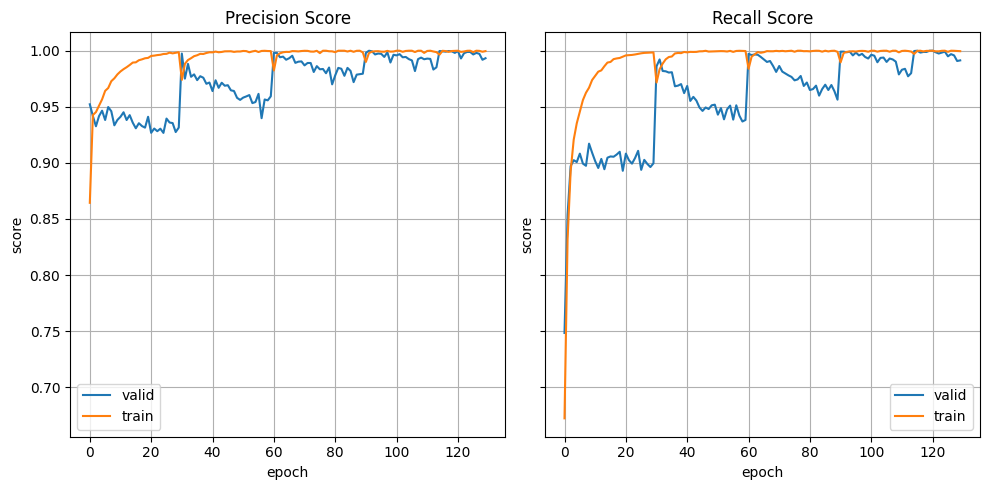

In [212]:
valid_precision_score = [item for history in histories for item in history['val_precision']]
train_precision_score = [item for history in histories for item in history['precision']]
valid_recall_score = [item for history in histories for item in history['val_recall']]
train_recall_score = [item for history in histories for item in history['recall']]


fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].plot(valid_precision_score, label='valid')
axes[0].plot(train_precision_score, label='train')
axes[0].set_title('Precision Score')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('score')
axes[0].legend()
axes[0].grid()

axes[1].plot(valid_recall_score, label='valid')
axes[1].plot(train_recall_score, label='train')
axes[1].set_title('Recall Score')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('score')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

### **7.5. Model Test Evaluation**

In [213]:
X_test_inputs = [np.vstack(X_test['text_embedded__left']), np.vstack(X_test['text_embedded__right'])]
y_pred_probs = training_model.predict(X_test_inputs)
y_pred = (y_pred_probs >= 0.5).astype(int)

precision_sc = precision_score(y_test, y_pred)
recall_sc = recall_score(y_test, y_pred)
f1_sc = f1_score(y_test, y_pred)

print(f'Precision: {precision_sc:.5f}')
print(f'Recall: {recall_sc:.5f}')
print(f'F1: {f1_sc:.5f}')

1959/1959 [==============================] - 3s 2ms/step
Precision: 0.92835
Recall: 0.90968
F1: 0.91892


### **7.6. Embedding Model Preparation**

We have successfully obtained a model capable of detecting whether a pair of reports are duplicates or not. However, directly using this model for duplicate report detection and determining which report has been duplicated (unique report) poses an issue. Each time a new report is added, it requires checking against all existing unique reports, which is inefficient. For instance, in the context of the data used in this project, there are 183,180 unique reports and 25,686 duplicate reports. Hence, it would require a total of 183,180 * 25,686 = `4,705,161,480 model inferences`!

Therefore, we need to employ another method, adopting the approach used in training Word2Vec using the Continuous Bag of Words (CBOW) technique. Here, `we use the output from the projection layer as the vector representation of the report` and perform cosine similarity search to find similar or duplicate reports.

### **7.6.1. Get Dense Embedding Model**

In [214]:
embd_input = Input(shape=(num_dim, ), name='input')
embd_output = training_model.get_layer('shared_node_1')(embd_input)

embd_model = Model(inputs=embd_input, outputs=embd_output, name='embd_inference_model')
embd_model.summary()

Model: "embd_inference_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 384)]             0         
                                                                 
 shared_node_1 (Dense)       (None, 256)               98560     
                                                                 
Total params: 98560 (385.00 KB)
Trainable params: 98560 (385.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **7.6.2. Get LSTM Embedding Model**

In [215]:
%%script skipped # Skipped

embd_input = Input(shape=(num_dim, ), name='input')
embd_x = training_model.get_layer('reshape_node_1')(embd_input)
embd_x = training_model.get_layer('shared_node_1')(embd_x)
embd_x = training_model.get_layer('shared_node_2')(embd_x)
embd_output = training_model.get_layer('shared_node_3')(embd_x)

embd_model = Model(inputs=embd_input, outputs=embd_output, name='embd_inference_model')
embd_model.summary()

Couldn't find program: 'skipped'


### **7.7. Embedding Model Evaluation**

In [216]:
def custom_cosine_similarity(text_1: np.ndarray, text_2: np.ndarray):
    dot_product = np.dot(text_1, text_2)
    norm_text_1 = np.linalg.norm(text_1)
    norm_text_2 = np.linalg.norm(text_2)
    
    similarity = dot_product / (norm_text_1 * norm_text_2)
    return similarity

In [217]:
embd_test_left = embd_model.predict(np.vstack(X_test['text_embedded__left']))
embd_test_right = embd_model.predict(np.vstack(X_test['text_embedded__right']))

embd_similarity = np.array([custom_cosine_similarity(embd_1, embd_2) for embd_1, embd_2 in zip(embd_test_left, embd_test_right)])

1959/1959 [==============================] - 2s 941us/step


In [218]:
def evaluate_model(similarity_scores: np.ndarray, threshold: float):
  embd_binary_similarity = (similarity_scores > threshold).astype(int)

  precision = precision_score(y_test, embd_binary_similarity)
  recall = recall_score(y_test, embd_binary_similarity)
  f1 = f1_score(y_test, embd_binary_similarity)
  
  return [precision, recall, f1]

In [219]:
threshold_eval = pd.DataFrame(
  data=[[threshold, *evaluate_model(embd_similarity, threshold)] for threshold in np.linspace(0, 1, 1000)],
  columns=['threshold', 'precision', 'recall', 'f1'])

threshold_eval_sorted = threshold_eval.sort_values(by='f1', ascending=False)
threshold_eval_sorted

,threshold,precision,recall,f1
386,0.386386,0.940163,0.899169,0.919209
385,0.385385,0.939304,0.899689,0.919069
370,0.370370,0.925853,0.912276,0.919014
381,0.381381,0.935241,0.903322,0.919005
384,0.384384,0.938210,0.900467,0.918951
...,...,...,...,...
995,0.995996,1.000000,0.017908,0.035186
996,0.996997,1.000000,0.017519,0.034434
997,0.997998,1.000000,0.017259,0.033933
998,0.998999,1.000000,0.017130,0.033682


<Axes: title={'center': 'Metrics Evaluation'}, xlabel='Threshold', ylabel='Metric score'>

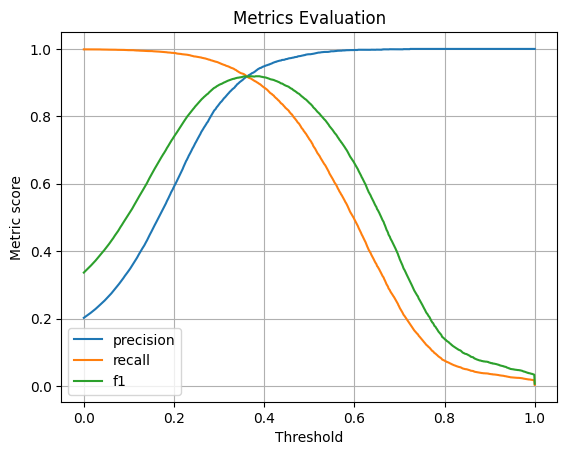

In [220]:
threshold_eval.plot(
  kind='line',
  title='Metrics Evaluation',
  x='threshold',
  xlabel='Threshold',
  ylabel='Metric score',
  grid=True)

In [221]:
threshold_opt = threshold_eval_sorted['threshold'].iloc[0]
model_eval = evaluate_model(embd_similarity, threshold_opt)

print(f'Precision: {model_eval[0]:.5f}')
print(f'Recall: {model_eval[1]:.5f}')
print(f'F1: {model_eval[2]:.5f}')

Precision: 0.94016
Recall: 0.89917
F1: 0.91921


### **8. Similarity Search**

### **8.1. Prepare Data**

We need to prepare the data for testing similarity search. This includes the testing data (`df_sim_search_test`), which consists of pairs of vectors (embedded report text) and `id_match` (id of the duplicated report), and the data collection from unique reports (`df_sim_search_data`), which consists of vectors (embedded report text) and report IDs used as the `master dataset`.

In [222]:
column_mapper = {
  'id__left': 'id',
  'text_embedded__left': 'vector',
  'id__right': 'id_match',
}

df_sim_search_test = df[df['label'] == 1][['id__left', 'text_embedded__left', 'id__right']].rename(columns=column_mapper)
df_sim_search_test

,id,vector,id_match
7,293631,"[0.03956199, -0.04356538, 0.016794298, -0.0047...",293630.0
40,379544,"[-0.0070534744, 0.053230204, -0.02449986, 0.01...",378837.0
52,220265,"[0.0006551796, -0.029087212, -0.006409261, 0.0...",216602.0
55,1549034,"[-0.0062051797, -0.0079135, 0.0073644766, 0.00...",1548990.0
60,230922,"[0.063632436, 0.03333981, -0.040277764, -0.004...",216432.0
...,...,...,...
208816,555054,"[0.025442548, 0.015526013, 0.045115303, -0.002...",544672.0
208829,266967,"[-0.03685053, -0.056290228, -0.08407612, 0.033...",255637.0
208841,324858,"[0.037113402, -0.11462945, 0.011635334, -0.001...",324763.0
208846,220068,"[-0.06483394, 0.016236242, -0.00046764239, 0.0...",214121.0


In [223]:
column_mapper = {
  'id__left': 'id',
  'text_embedded__left': 'vector',
}

df_sim_search_data = df[['id__left', 'text_embedded__left']].rename(columns=column_mapper)
df_sim_search_data = df_sim_search_data[~df_sim_search_data['id'].isin(df_sim_search_test['id'])]
df_sim_search_data

,id,vector
0,685958,"[0.036902905, -0.035959516, 0.017000956, -0.04..."
1,1246857,"[0.013780104, -0.034500245, -0.0673427, 0.0041..."
2,1206916,"[0.013095676, -0.01894292, 0.011076523, -0.004..."
3,538897,"[-0.037188318, -0.08663432, 0.08391913, -0.035..."
4,257995,"[-0.0681053, -0.07650347, 0.085386515, 0.01524..."
...,...,...
208861,1603531,"[-0.01886405, -0.031196129, 0.02678858, 0.0143..."
208862,1692276,"[0.009130968, -0.02435595, -0.093101114, -0.04..."
208863,525188,"[-0.0039968286, 0.012683702, 0.0096171135, -0...."
208864,1548644,"[-0.048929468, -0.06869774, 0.033939254, -0.05..."


### **8.2. Create Faiss Index**

To facilitate the similarity search process, we will utilize the `faiss` library with 500 partitions to expedite the searching process. To use the cosine similarity index, we need to employ the `IndexIVFFlat` index with `METRIC_INNER_PRODUCT` and normalize the vectors from the master dataset before inserting them into the index.

In [224]:
base_vectors = np.vstack(df_sim_search_data['vector'])
mod_vectors = embd_model.predict(base_vectors)

vector_dim = 256
ids = df_sim_search_data['id']

nlist = 500
quantizer = faiss.IndexFlatIP(vector_dim)
index = faiss.IndexIVFFlat(quantizer, vector_dim, nlist, faiss.METRIC_INNER_PRODUCT)

faiss.normalize_L2(mod_vectors)

index.train(mod_vectors)
index.add_with_ids(mod_vectors, ids)

5725/5725 [==============================] - 8s 1ms/step


### **8.3. Perform Similarity Search**

Kita melakukan search terhadap 10 data terdekat yang memiliki similarity score di atas `threshold_opt`.

In [225]:
index.nprobe = 20
k = 10

_base_vector = np.vstack(df_sim_search_test['vector'])
_mod_vectors = embd_model.predict(_base_vector)
faiss.normalize_L2(_mod_vectors)

search_result = index.search(_mod_vectors, k=k)

803/803 [==============================] - 1s 1ms/step


In [226]:
ids_search = []

for scores, ids_match in zip(search_result[0], search_result[1]):
  filtered = [res[1] for res in zip(scores, ids_match) if res[0] > threshold_opt]
  ids_search.append(filtered)

### **8.4. Similarity Search Evaluation**

The metric used to measure the performance of similarity search is recall@10. This metric evaluates the recall value with true positives determined by the presence of `id_match` in the top 10 most similar report data.

In [227]:
ids_actual = ids_search
ids_expected = df_sim_search_test['id_match']

true_result = [1] * len(df_sim_search_test)
results = []
for id_actual, id_expected in zip(ids_actual, ids_expected):
  if id_expected in id_actual:
    results.append(1)
  else:
    results.append(0)

recall_sc = recall_score(true_result, results)

print(f'Recall@{k}: {recall_sc}')

Recall@10: 0.33010200109008797


It appears that the recall@10 value obtained is 0.3301, which is relatively small. However, by utilizing this model, we are potentially able to reduce 33.01% of duplicated bug reports reported by users. Recognizing this potential, we see the opportunity for this model to be implemented in the system.